# Import all Moduls

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets,models,transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()

# Load Data

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(232),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ])}

data_dir = 'Images'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x),
                                            data_transforms[x])
                  for x in ['train','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=2)
               for x in ['train','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualize a few images

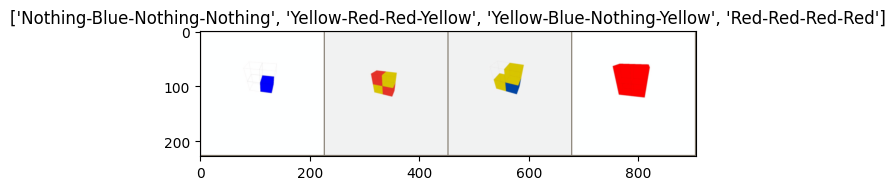

In [3]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Model Training

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    best_model_params_path = os.path.join('Model', 'best_model_params.pt')

    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

# Visualizing the model predicitions

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Finetuning the ConvNet

In [6]:
model_ft = models.mobilenet_v2(weights='IMAGENET1K_V1')
num_ftrs = model_ft.classifier[1].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.classifier[1] = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=13)

Epoch 0/12
----------
train Loss: 3.0822 Acc: 0.3616
test Loss: 0.3786 Acc: 0.9808

Training complete in 0m 51s
Best val Acc: 0.980769
Epoch 1/12
----------
train Loss: 0.4267 Acc: 0.9806
test Loss: 0.0195 Acc: 1.0000

Training complete in 1m 39s
Best val Acc: 1.000000
Epoch 2/12
----------
train Loss: 0.1054 Acc: 0.9994
test Loss: 0.0069 Acc: 1.0000

Training complete in 2m 28s
Best val Acc: 1.000000
Epoch 3/12
----------
train Loss: 0.1086 Acc: 0.9996
test Loss: 0.0073 Acc: 1.0000

Training complete in 3m 15s
Best val Acc: 1.000000
Epoch 4/12
----------
train Loss: 0.1116 Acc: 0.9996
test Loss: 0.0052 Acc: 1.0000

Training complete in 4m 4s
Best val Acc: 1.000000
Epoch 5/12
----------
train Loss: 0.1059 Acc: 0.9992
test Loss: 0.0061 Acc: 1.0000

Training complete in 4m 52s
Best val Acc: 1.000000
Epoch 6/12
----------
train Loss: 0.1111 Acc: 0.9996
test Loss: 0.0079 Acc: 1.0000

Training complete in 5m 40s
Best val Acc: 1.000000
Epoch 7/12
----------
train Loss: 0.1303 Acc: 0.9998
tes

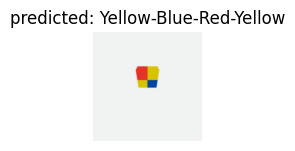

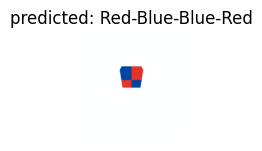

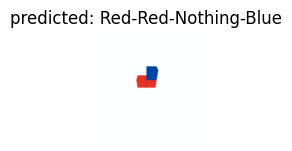

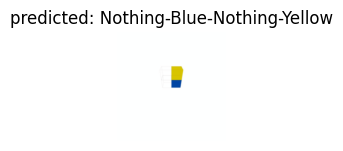

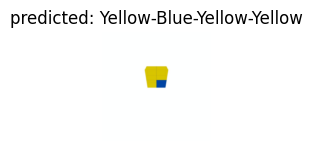

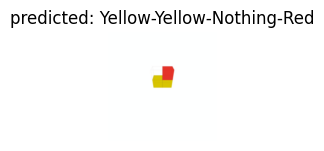

In [8]:
visualize_model(model_ft)

# ConvNet as fixed feature extractor

In [9]:
model_conv = torchvision.models.mobilenet_v2(weights='IMAGENET1K_V2')
for param in model_conv.parameters():
    param.requires_grad = True

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier[1] = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [10]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=13)

Epoch 0/12
----------
train Loss: 4.2129 Acc: 0.1564
test Loss: 1.7347 Acc: 0.5459

Training complete in 0m 49s
Best val Acc: 0.545858
Epoch 1/12
----------
train Loss: 0.8264 Acc: 0.8305
test Loss: 0.1386 Acc: 0.9926

Training complete in 1m 37s
Best val Acc: 0.992604
Epoch 2/12
----------
train Loss: 0.1261 Acc: 0.9973
test Loss: 0.0231 Acc: 1.0000

Training complete in 2m 26s
Best val Acc: 1.000000
Epoch 3/12
----------
train Loss: 0.0541 Acc: 0.9994
test Loss: 0.0127 Acc: 1.0000

Training complete in 3m 14s
Best val Acc: 1.000000
Epoch 4/12
----------
train Loss: 0.0525 Acc: 0.9996
test Loss: 0.0141 Acc: 1.0000

Training complete in 4m 2s
Best val Acc: 1.000000
Epoch 5/12
----------
train Loss: 0.0506 Acc: 0.9996
test Loss: 0.0197 Acc: 1.0000

Training complete in 4m 51s
Best val Acc: 1.000000
Epoch 6/12
----------
train Loss: 0.0531 Acc: 0.9992
test Loss: 0.0121 Acc: 1.0000

Training complete in 5m 40s
Best val Acc: 1.000000
Epoch 7/12
----------
train Loss: 0.0609 Acc: 0.9996
tes

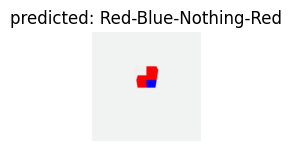

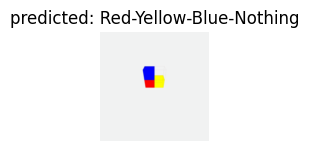

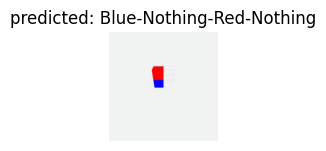

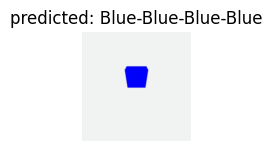

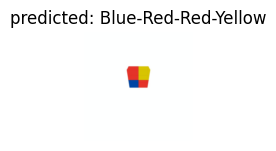

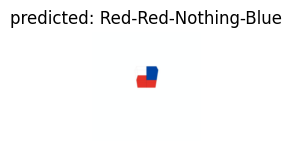

In [11]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [12]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['test'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])
        print(class_names[preds[0]])

        model.train(mode=was_training)

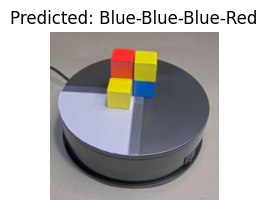

Blue-Blue-Blue-Red


In [13]:
visualize_model_predictions(
    model_conv,
    img_path='Images/test/Bild.png'
)


plt.ioff()
plt.show()

# Bilderkennung

In [14]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['test'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)
        
        detected_label = class_names[preds[0]]
        cubes = detected_label.split("-")

        model.train(mode=was_training)
        return cubes

In [15]:
visualize_model_predictions(
    model_conv,
    img_path='Images/test/Yellow-Red-Yellow-Yellow/Yellow-Red-Yellow-Yellow3.jpg'
)

['Yellow', 'Red', 'Yellow', 'Yellow']

# Load the Model from a Folder

In [19]:
model.load_state_dict(torch.load(PATH))
model.eval()

NameError: name 'model' is not defined

In [ ]:
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0